<a href="https://colab.research.google.com/github/dajebbar/ML/blob/main/ML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn import (
    ensemble,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC,
)
from yellowbrick.model_selection import (
    LearningCurve,
)

In [2]:
url = 'https://hbiostat.org/data/repo/titanic3.xls'
origin_df = pd.read_excel(url)
origin_df.sample(n=8, random_state=42)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1148,3,0,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,NaN,NaN,NaN
1049,3,1,"Nakid, Mr. Sahid",male,20.0,1,1,2653,15.7417,NaN,C,C,NaN,NaN
982,3,0,"Lyntakoff, Mr. Stanko",male,NaN,0,0,349235,7.8958,NaN,S,NaN,NaN,NaN
808,3,0,"Ford, Mr. Arthur",male,NaN,0,0,A/5 1478,8.0500,NaN,S,NaN,NaN,"Bridgwater, Somerset, England"
1195,3,0,"Shaughnessy, Mr. Patrick",male,NaN,0,0,370374,7.7500,NaN,Q,NaN,NaN,NaN
240,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S,9,NaN,"New York, NY"
1118,3,0,"Peltomaki, Mr. Nikolai Johannes",male,25.0,0,0,STON/O 2. 3101291,7.9250,NaN,S,NaN,NaN,NaN
596,2,1,"Wilhelms, Mr. Charles",male,31.0,0,0,244270,13.0000,NaN,S,9,NaN,"London, England"


In [3]:
origin_df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [4]:
origin_df.shape

(1309, 14)

In [5]:
origin_df.describe().T

,count,mean,std,min,25%,50%,75%,max
pclass,1309.0,2.294882,0.837836,1.0000,2.0000,3.0000,3.000,3.0000
survived,1309.0,0.381971,0.486055,0.0000,0.0000,0.0000,1.000,1.0000
age,1046.0,29.881135,14.413500,0.1667,21.0000,28.0000,39.000,80.0000
sibsp,1309.0,0.498854,1.041658,0.0000,0.0000,0.0000,1.000,8.0000
parch,1309.0,0.385027,0.865560,0.0000,0.0000,0.0000,0.000,9.0000
fare,1308.0,33.295479,51.758668,0.0000,7.8958,14.4542,31.275,512.3292
body,121.0,160.809917,97.696922,1.0000,72.0000,155.0000,256.000,328.0000


## Missing values

In [6]:
origin_df.isnull().mean().mul(100)

pclass        0.000000
survived      0.000000
name          0.000000
sex           0.000000
age          20.091673
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.076394
cabin        77.463713
embarked      0.152788
boat         62.872422
body         90.756303
home.dest    43.086325
dtype: float64

Missing values trough samples(rows)

In [7]:
origin_df.isnull().mean(axis=1).mul(100)

0        7.142857
1        7.142857
2       14.285714
3        7.142857
4       14.285714
          ...    
1304    21.428571
1305    35.714286
1306    21.428571
1307    28.571429
1308    28.571429
Length: 1309, dtype: float64

In [8]:
origin_df.sex.value_counts(normalize=True, dropna=False)

male      0.644003
female    0.355997
Name: sex, dtype: float64

In [9]:
origin_df.embarked.value_counts(normalize=True, dropna=False)

S      0.698243
C      0.206264
Q      0.093965
NaN    0.001528
Name: embarked, dtype: float64

## Create features
create dummy columns for categorical low cardinality features and drop leaky columns and also who don't give signal to our model.

In [10]:
origin_df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [11]:
origin_df.drop(columns=['name',
                        'ticket',
                       'cabin',
                       'boat',
                        'body',
                        'home.dest'], 
               inplace=True)

We need to create dummy columns from string columns. This
will create new columns for sex and embarked.

In [12]:
origin_df = pd.get_dummies(origin_df, drop_first=True)
origin_df.head()

,pclass,survived,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,0,0,1
1,1,1,0.9167,1,2,151.5500,1,0,1
2,1,0,2.0000,1,2,151.5500,0,0,1
3,1,0,30.0000,1,2,151.5500,1,0,1
4,1,0,25.0000,1,2,151.5500,0,0,1


Create a DataFrame (X) with the features and a series (y) with
the labels

In [13]:
X = origin_df.drop(columns='survived')
y = origin_df.survived

## Sample data

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=.3, random_state=42,
)

## Impute data
Impute data in train dataset and then use the imputer to fill in the test dataset.

In [15]:
from sklearn.experimental import (
    enable_iterative_imputer,
)

from sklearn import impute
import numpy as np

In [16]:
X_train.isnull().any()

pclass        False
age            True
sibsp         False
parch         False
fare           True
sex_male      False
embarked_Q    False
embarked_S    False
dtype: bool

In [17]:
num_col = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male']

imputer = impute.IterativeImputer()
# train
imputed = imputer.fit_transform(X_train[num_col])
X_train.loc[:, num_col] = imputed
# test
imputed = imputer.transform(X_test[num_col])
X_test.loc[:, num_col] = imputed

In [18]:
X_train.isnull().sum()

pclass        0
age           0
sibsp         0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64

In [19]:
X_test.isnull().sum()

pclass        0
age           0
sibsp         0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64

In [20]:
y_train.isnull().sum(), y_test.isnull().sum()

(0, 0)

In [21]:
X_train.shape, y_train.shape

((916, 8), (916,))

In [22]:
X_test.shape, y_test.shape

((393, 8), (393,))

## Normalize Data
Normalize data without normalize dummiy columns

In [23]:
std_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']
std = preprocessing.StandardScaler()
fitted = std.fit_transform(X_train[std_cols])
X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
test_fit = std.transform(X_test[std_cols])
X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

In [24]:
# n_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']
# X_tr_norm = X_train.iloc[:, :5]
# X_tr_cat = X_train.iloc[:, 5:]
# sca = preprocessing.StandardScaler()
# X_tr_norm = sca.fit_transform(X_tr_norm)
# X_tr_norm = pd.DataFrame(data=X_tr_norm, columns=n_cols)
# X_train = pd.concat([X_tr_norm, X_tr_cat])

# X_train.head()

In [25]:
# n_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']
# X_tr_norm = X_train.iloc[:, :5]
# X_tr_cat = X_train.iloc[:, 5:]

In [26]:
# X_tr_norm.head()

In [27]:
# X_tr_norm.shape

In [28]:
# X_tr_cat.head()

In [29]:
# X_tr_cat.shape

In [30]:
# sca = preprocessing.StandardScaler()
# # X_tr_norm = sca.fit_transform(X_tr_norm)
# X_tr_norm = pd.DataFrame(data=X_tr_norm, columns=n_cols)

In [31]:
# X_tr_norm.head()

In [32]:
# X_tr_norm.shape

In [33]:
# X_tr_norm.isnull().any()

In [34]:
# X_tr_cat.isnull().any()

In [35]:
# header = ['pclass', 'age', 'sibsp', 'parch', 'fare', 
#           'sex_male', 'embarked_Q', 'embarked_S']
# X_train = pd.concat([X_tr_norm, X_tr_cat], axis=1, keys=header)
# X_train.head()

In [36]:
# X_train.tail()

In [37]:
# X_train.shape, X_tr_norm.shape, X_tr_cat.shape

In [38]:
X_train.isnull().any()

pclass        False
age           False
sibsp         False
parch         False
fare          False
sex_male      False
embarked_Q    False
embarked_S    False
dtype: bool

## Base Line Model

In [39]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test) # Accuracy

0.5699745547073791

In [40]:
from sklearn import metrics
metrics.precision_score(y_test, bm.predict(X_test))

0.0

## Various Families
This code tries a variety of algorithm families. The “No Free
Lunch” theorem states that no algorithm performs well on all
data. However, for some finite set of data, there may be an algo‐
rithm that does well on that set.

Here we use a few different families and compare the AUC score and standard deviation using k-fold cross-validation. An algorithm that has a slightly smaller average score but tighter standard deviation might be a better choice.

Because we are using k-fold cross-validation, we will feed the
model all of X and y

In [41]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [42]:
X.isnull().any()

pclass        False
age           False
sibsp         False
parch         False
fare          False
sex_male      False
embarked_Q    False
embarked_S    False
dtype: bool

In [43]:
X.shape, y.shape

((1309, 8), (1309,))

In [44]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier

from sklearn. linear_model import (
    LogisticRegression,
)

from sklearn.tree import (
    DecisionTreeClassifier,
)

from sklearn.neighbors import (
    KNeighborsClassifier,
)

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import (
    RandomForestClassifier,
)

import xgboost

In [45]:
models = [
          DummyClassifier,
          LogisticRegression,
          DecisionTreeClassifier,
          KNeighborsClassifier,
          GaussianNB,
          SVC, 
          RandomForestClassifier,
          xgboost.XGBClassifier,
        ]
        
# for model in models:
#   cls = model()
#   kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
#   s = model_selection.cross_val_score(cls, X, y, scoring='roc_auc', cv=kfold)

#   print(
#       f'{model.__name__:22}  AUC: '
#       f'{s.mean():.3f} STD: {s.std():.2f}'
#   )

for model in models:
    cls = model()
    kfold = model_selection.KFold(
        n_splits=10, random_state=42,
        shuffle=True
    )
    s = model_selection.cross_val_score(
        cls, X, y, scoring="roc_auc", cv=kfold
    )
    print(
        f"{model.__name__:22}  AUC: "
        f"{s.mean():.3f} STD: {s.std():.2f}"
    )

DummyClassifier         AUC: 0.500 STD: 0.00
LogisticRegression      AUC: 0.840 STD: 0.04
DecisionTreeClassifier  AUC: 0.760 STD: 0.03
KNeighborsClassifier    AUC: 0.830 STD: 0.02
GaussianNB              AUC: 0.812 STD: 0.05
SVC                     AUC: 0.838 STD: 0.03
RandomForestClassifier  AUC: 0.845 STD: 0.02
XGBClassifier           AUC: 0.862 STD: 0.03


## Stacking

If you were going down the Kaggle route (or want maximum performance at the cost of interpretability), stacking is an option. A stacking classifier takes other models and uses their output to predict a target or label. We will use the previous models’ outputs and combine them to see if a stacking classifier can do better.

In [46]:
# !pip install mlxtend --quiet

In [47]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

from mlxtend.classifier import (
    StackingClassifier,
)


In [48]:
models = [
        LogisticRegression,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
    ]

clfs = [x() for x in models]

stack = StackingClassifier(
    classifiers=clfs,
    meta_classifier=LogisticRegression(),
)
kfold = model_selection.KFold(
    n_splits=10, random_state=42,
    shuffle=True
)
s = model_selection.cross_val_score(
    stack, X, y, scoring="roc_auc", cv=kfold
)
print(
    f"{stack.__class__.__name__}  "
    f"AUC: {s.mean():.3f}  STD: {s.std():.2f}"
)

StackingClassifier  AUC: nan  STD: nan


## Create a model


In [49]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100, random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate a model

In [50]:
rf.score(X_test, y_test)

0.8040712468193384

Look at other metrics, such as precision

In [51]:
metrics.precision_score(
    y_test,
    rf.predict(X_test)
)

0.815068493150685

A nice benefit of tree-based models is that you can inspect the feature importance. The feature importance tells you how much a feature contributes to the model. Note that removing a feature doesn’t mean that the score will go down accordingly, as other features might be colinear (in this case we could remove either the sex_male or sex_female column as they have a perfect negative correlation):

In [52]:
for col, val in sorted(
    zip(
        X_train.columns,
        rf.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

age            0.282
fare           0.269
sex_male       0.236
pclass         0.090
sibsp          0.050


## Optimize Model
Models have hyperparameters that control how they behave. By
varying the values for these parameters, we change their per‐
formance. Sklearn has a grid search class to evaluate a model
with different combinations of parameters and return the best
result. We can use those parameters to instantiate the model
class

In [53]:
rf4 = ensemble.RandomForestClassifier()
params = {
    "max_features": [0.4, "auto"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}
cv = model_selection.GridSearchCV(
    rf4, params, n_jobs=-1
).fit(X_train, y_train)
print(cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [54]:
rf5 = ensemble.RandomForestClassifier(
    **{
        "max_features": .4,
        "min_samples_leaf": 1,
        "n_estimators": 200,
        "random_state": 42,
    }
)
rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)

0.7989821882951654

## Confusion Matrix
A confusion matrix allows us to see the correct classifications
as well as false positives and false negatives. It may be that we
want to optimize toward false positives or false negatives, and
different models or parameters can alter that.

In [55]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[196,  28],
       [ 51, 118]])

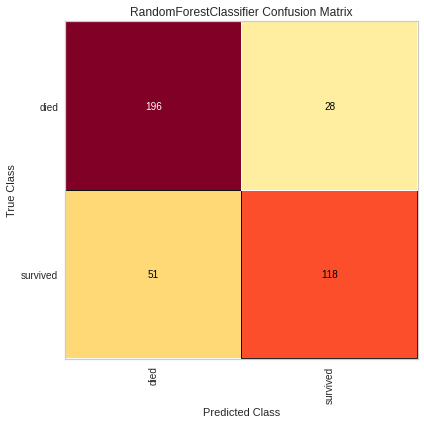

In [56]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    rf5,
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()

## ROC Curve
A receiver operating characteristic (ROC) plot is a common
tool used to evaluate classifiers. By measuring the area under
the curve (AUC), we can get a metric to compare different clas‐
sifiers It plots the true positive rate against the
false positive rate

In [57]:
y_pred = rf5.predict(X_test)
roc_auc_score(y_test, y_pred)

0.786612426035503

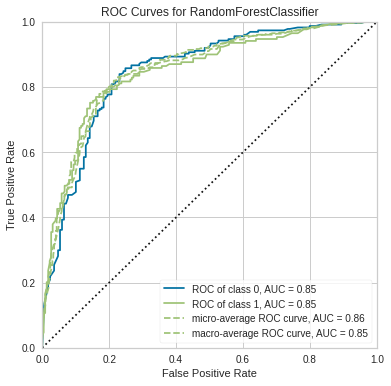

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(rf5)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.poof()
fig.savefig("mlpr_0305.png")

## Learning Curve
A learning curve is used to tell us if we have enough training data. It trains the model with increasing portions of the data and measures the score. If the cross-validation score continues to climb, then we might need to invest in gathering more data

In [63]:
X.isnull().sum()

pclass        0
age           0
sibsp         0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64

In [64]:
y.isnull().any()

False

ValueError: ignored

TypeError: ignored

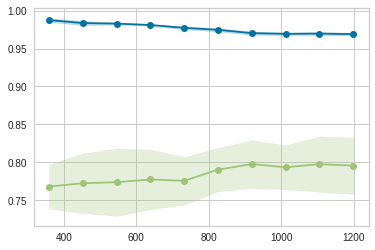

In [66]:
import numpy as np
fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    rf5,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=4,
    ax=ax,
)
lc_viz.fit(X, y)
# lc_viz.proof()


In [61]:
fig.savefig("mlpr_0306.png")

This learning curve shows that as we add more training
samples, our cross-validation (testing) scores appear to not improve.

## Deploy Model
Using Python’s pickle module, we can persist models and load
them. Once we have a model, we call the .predict method to
get a classification or regression result

In [62]:
import pickle
pic = pickle.dumps(rf5)
rf6 = pickle.loads(pic)

y_pred = rf6.predict(X_test)
roc_auc_score(y_test, y_pred)

0.786612426035503